## 1) Data Analysis

In [1]:
import torch
from pathlib import Path
from dataset import GraspDataset

# Create dataset
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

# Get a single sample
sample = dataset[1]

# Print available keys
print("Sample contains the following keys:")
for key in sample.keys():
    print(f"- {key}")

# Print tensor shapes and data types
print("\nShapes:")
for key, tensor in sample.items():
    if key == "scene_idx" or key == "grasp_idx":
        continue
    print(f"{key}: {tensor.shape}")

# Basic statistics for numerical tensors
print("\nBasic statistics:")
for key, tensor in sample.items():
    if key == "scene_idx" or key == "grasp_idx" or key == "score":
        continue
    if torch.is_floating_point(tensor):
        print(f"{key}:")
        print(f"  Min: {tensor.min().item():.4f}")
        print(f"  Max: {tensor.max().item():.4f}")
        print(f"  Mean: {tensor.mean().item():.4f}")
        print(f"  Std: {tensor.std().item():.4f}")
        print()

print(f"Score: {sample['score']}")


Sample contains the following keys:
- sdf
- grasp
- score
- scene_idx
- grasp_idx

Shapes:
sdf: torch.Size([48, 48, 48])
grasp: torch.Size([19])
score: torch.Size([])

Basic statistics:
sdf:
  Min: -0.7169
  Max: 1.4683
  Mean: 0.6416
  Std: 0.2782

grasp:
  Min: -0.2937
  Max: 1.8255
  Mean: 0.3404
  Std: 0.5473

Score: 0.33304598927497864


## 2) Overfitting on 1 sample

In [2]:
from pathlib import Path
from dataset import GraspDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import math

### 2.1) Initialize the model

In [3]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator(
    input_size=48,
    base_channels=16,
    fc_dims=[256, 128, 64]
).to(device)

Using device: cpu
Initializing GQEstimator
Input size: 48
Flattened size: 3456
Number of parameters: 1222049


### 2.2) Get a small number of samples

In [4]:
# Create dataset
data_path = Path('data/processed')

dataset = GraspDataset(data_path)
print("len(dataset): ", len(dataset))

def get_samples(dataset, num_samples):
    # Get num_samples many unique indices
    indices = torch.randperm(len(dataset))[:num_samples]
    samples = []
    print("Scene indices: ", indices)
    for i in indices:
        # Choose random grasp from scene
        sample = dataset[i]
        samples.append(sample)
    return samples

samples = get_samples(dataset, 10)

for i, sample in enumerate(samples[:3]):
    print(f"Sample {i}:")
    print("\tgrasp: ", sample['grasp'].tolist())
    print("\tscore: ", sample['score'].item())


print(samples[0]['grasp'].shape)
print(samples[0]['score'].shape)
print(samples[0]['sdf'].shape)



len(dataset):  7462560
Scene indices:  tensor([6212245, 4311537, 3622143,  954672, 4047315, 1407584, 5145161, 3381037,
          75766, 5979714])
Sample 0:
	grasp:  [0.06408321857452393, 0.014916861429810524, 0.2829621136188507, 0.9840953946113586, -0.036999788135290146, -0.16905753314495087, 0.0400857999920845, -0.03852662816643715, -0.14906585216522217, 0.33989545702934265, -0.2187262624502182, -0.03906584903597832, 0.249733105301857, -0.23981529474258423, 0.0009341436671093106, 0.2580556869506836, -0.3212704062461853, 0.16093413531780243, 0.16526134312152863]
	score:  1.4937500953674316
Sample 1:
	grasp:  [-0.03293197602033615, -0.019420089200139046, 0.2871796488761902, -0.21385937929153442, 0.9675678014755249, 0.01678565703332424, 0.1333979368209839, 0.306367427110672, -0.10906585305929184, 0.3082764446735382, -0.26800212264060974, 0.0909341499209404, 0.24546706676483154, -0.519659698009491, 0.020934155210852623, 0.28546708822250366, -0.3938348889350891, 0.22093413770198822, 0.0335

### 2.3) Overfit on these samples from that one scene

100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


[33.852535003143565, 33.82564838450344, 33.80239131335111, 33.78054148642987, 33.755153924250045, 33.72462977670948, 33.6906148870592, 33.65138012394309, 33.60318425199948, 33.54404980414547, 33.46539399898611, 33.37431283313781, 33.26452881507576, 33.127338499575856, 32.9278526108712, 32.66041946709156, 32.302463410794736, 31.83510336726904, 31.258318695425988, 30.54397416114807, 29.713161358237265, 28.80234619230032, 27.858371981047092, 26.954981437139214, 26.147606919333338, 25.47512131119147, 24.959192992560567, 24.57851778450422, 24.318386101722716, 24.14395805373788, 24.024524487555027, 23.943235252797603, 23.88658289909363, 23.845990458130835, 23.815415593981744, 23.791451600193977, 23.772195053100585, 23.756141915917397, 23.742214417457582, 23.727302134037018, 23.718454712629317, 23.70919724702835, 23.700012734532358, 23.690501090884208, 23.68138506114483, 23.672595292329788, 23.664178279042243, 23.655999186635018, 23.648153099417687, 23.640522351861, 23.63311766088009, 23.6258

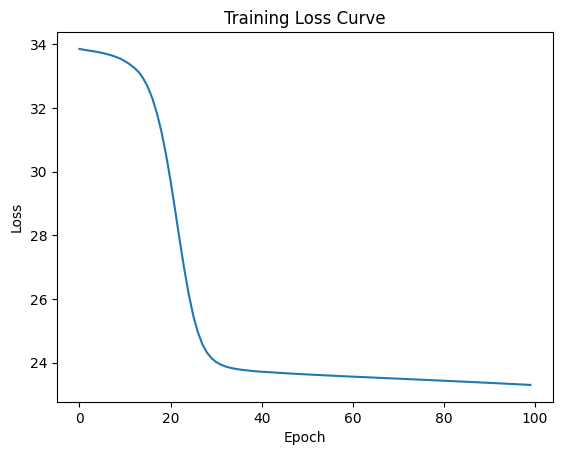

In [5]:
EPOCHS = 100

losses = []

# Play around with the learning rate and run this cell multiple times 
# to see how it affects the loss curve
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    for sample in samples:
        optimizer.zero_grad()
        sdf_features = model.encode_sdf(sample['sdf'])
        flattened_features = torch.cat([sdf_features, sample['grasp']])
        pred_quality = model(flattened_features).squeeze()
        loss = criterion(pred_quality, sample['score'])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(samples)
    losses.append(epoch_loss)

print(losses)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


## 3) Full Training

### 3.2) Create the datasets

In [6]:
import random

# Load the dataset
dataset = GraspDataset(data_path)

# Split dataset into training and validation
val_split = 0.2
num_samples = len(dataset)
train_size = int(num_samples * (1 - val_split))
val_size = num_samples - train_size

print(f"Subset samples: {num_samples}, Calculated train size: {train_size}, Calculated val size: {val_size}")

# Shuffle indices
random.seed(42)
indices = list(range(num_samples))
random.shuffle(indices)

# Split indices
train_indices = indices[:1000]
val_indices = indices[-100:]

# Create Subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Subset samples: 7462560, Calculated train size: 5970048, Calculated val size: 1492512
Train dataset size: 1000, Validation dataset size: 100


In [ ]:
import random
from pathlib import Path
from dataset import GraspDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
import torch

# --- Configuration ---
LEARNING_RATE = 1e-3
EPOCHS = 100
VAL_SPLIT = 0.2
BASE_CHANNELS = 4
FC_DIMS = [32, 8]
BATCH_SIZE = 32
NUM_WORKERS = 1

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Dataset and Dataloaders ---
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

num_samples = len(dataset)
train_size = int(num_samples * (1 - VAL_SPLIT))
val_size = num_samples - train_size
print(f"Total scenes: {num_samples}, Train scenes: {train_size}, Val scenes: {val_size}")

indices = list(range(num_samples))
random.seed(42)
random.shuffle(indices)

train_indices = indices[:5000]
val_indices = indices[-1000:]

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
print(f"Train dataset size: {len(train_set)}, Validation dataset size: {len(val_set)}")

# The dataloader now yields your desired batches directly!
# batch_size=None is important for iterable datasets that do their own batching.
pin_memory = torch.cuda.is_available()
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=True)

# Check data distribution:
print("\n=== Data Distribution Analysis ===")
train_scores = []
val_scores = []

for i in range(len(train_set)):
    train_scores.append(train_set[i]['score'].item())
    
for i in range(len(val_set)):
    val_scores.append(val_set[i]['score'].item())

train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

print(f"Train scores - Mean: {train_scores.mean():.3f}, Std: {train_scores.std():.3f}")
print(f"Val scores   - Mean: {val_scores.mean():.3f}, Std: {val_scores.std():.3f}")
print(f"Distribution difference: {abs(train_scores.mean() - val_scores.mean()):.3f}")

# --- Model, Optimizer, Loss ---
model = GQEstimator(input_size=48, base_channels=BASE_CHANNELS, fc_dims=FC_DIMS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# --- Training Loop ---
print(f"\nStarting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    num_steps = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training"):
        optimizer.zero_grad()

        # Move to device
        sdf_batch = batch['sdf'].to(device)
        grasp_batch = batch['grasp'].to(device)
        score_batch = batch['score'].to(device)

        # Get the actual batch size (handles variable batch sizes)
        actual_batch_size = sdf_batch.size(0)

        # 1. Encode SDF
        sdf_features = model.encode_sdf(sdf_batch)

        # 2. No need to expand - sdf_features is already (B, flattened_size)
        # 3. Concatenate features
        flattened_features = torch.cat([sdf_features, grasp_batch], dim=1)

        # 4. Predict grasp quality and compute loss
        pred_quality = model(flattened_features)
        loss = criterion(pred_quality, score_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * actual_batch_size
        num_steps += actual_batch_size

    scheduler.step()

    avg_train_loss = total_train_loss / num_steps

    # --- Validation Loop ---
    model.eval()
    total_val_loss = 0
    num_steps = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation"):
            sdf_batch = batch['sdf'].to(device)
            grasp_batch = batch['grasp'].to(device)
            score_batch = batch['score'].to(device)

            # Get the actual batch size (handles variable batch sizes)
            actual_batch_size = sdf_batch.size(0)

            # 1. Encode SDF
            sdf_features = model.encode_sdf(sdf_batch)

            # 2. No need to expand - sdf_features is already (B, flattened_size)
            # 3. Concatenate features
            flattened_features = torch.cat([sdf_features, grasp_batch], dim=1)

            # 4. Predict grasp quality and compute loss
            pred_quality = model(flattened_features)
            loss = criterion(pred_quality, score_batch)

            total_val_loss += loss.item() * actual_batch_size
            num_steps += actual_batch_size

    avg_val_loss = total_val_loss / num_steps
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# --- Save Model ---
model_path = "model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully to {model_path}")

Using device: cpu
Total scenes: 7462560, Train scenes: 5970048, Val scenes: 1492512
Train dataset size: 5000, Validation dataset size: 1000

=== Data Distribution Analysis ===
Train scores - Mean: 5.050, Std: 6.959
Val scores   - Mean: 5.118, Std: 7.064
Distribution difference: 0.068
Initializing GQEstimator
Input size: 48
Flattened size: 864
Number of parameters: 46873

Starting training for 100 epochs...


Epoch 1/100 Validation: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Epoch [1/100], Train Loss: 50.1658, Val Loss: 48.2879


Epoch 2/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s]


Epoch [2/100], Train Loss: 42.7466, Val Loss: 42.3842


Epoch 3/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.50it/s]


Epoch [3/100], Train Loss: 38.3407, Val Loss: 38.2104


Epoch 4/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.81it/s]


Epoch [4/100], Train Loss: 36.9187, Val Loss: 37.4240


Epoch 5/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.49it/s]


Epoch [5/100], Train Loss: 35.7061, Val Loss: 36.5506


Epoch 6/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.54it/s]


Epoch [6/100], Train Loss: 34.3336, Val Loss: 35.5981


Epoch 7/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.53it/s]


Epoch [7/100], Train Loss: 33.1086, Val Loss: 34.5169


Epoch 8/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.49it/s]


Epoch [8/100], Train Loss: 31.7449, Val Loss: 33.6585


Epoch 9/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.67it/s]


Epoch [9/100], Train Loss: 30.5637, Val Loss: 32.4458


Epoch 10/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s]


Epoch [10/100], Train Loss: 29.4651, Val Loss: 31.5068


Epoch 11/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.42it/s]


Epoch [11/100], Train Loss: 28.4583, Val Loss: 30.5775


Epoch 12/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.49it/s]


Epoch [12/100], Train Loss: 27.5832, Val Loss: 30.1039


Epoch 13/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s]


Epoch [13/100], Train Loss: 26.9205, Val Loss: 29.6695


Epoch 14/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.95it/s]


Epoch [14/100], Train Loss: 26.3757, Val Loss: 29.2969


Epoch 15/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.69it/s]


Epoch [15/100], Train Loss: 26.0673, Val Loss: 29.0342


Epoch 16/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]


Epoch [16/100], Train Loss: 25.5831, Val Loss: 28.7085


Epoch 17/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.56it/s]


Epoch [17/100], Train Loss: 25.2546, Val Loss: 28.6332


Epoch 18/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.68it/s]


Epoch [18/100], Train Loss: 24.9121, Val Loss: 28.3818


Epoch 19/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.82it/s]


Epoch [19/100], Train Loss: 24.6178, Val Loss: 28.0479


Epoch 20/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s]


Epoch [20/100], Train Loss: 24.3109, Val Loss: 27.8857


Epoch 21/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


Epoch [21/100], Train Loss: 23.4269, Val Loss: 27.8046


Epoch 22/100 Training:  24%|██▍       | 38/157 [00:10<00:33,  3.54it/s]